# Rolling Drawdown Filter for Cross-Sectional Momentum

Implementation of a rolling drawdown filter that stops investing when recent losses exceed a threshold.

**Filter Logic:**
- Monitor rolling 90-day drawdown on weekly frequency
- Stop investing when drawdown exceeds 10% threshold
- Resume investing when drawdown recovers
- No lookahead bias: filter uses data up to t-1

In [8]:
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cross_sectional_momentum import *

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.float_format', '{:.4f}'.format)

print("📊 Rolling Drawdown Filter Analysis")
print("=" * 50)

📊 Rolling Drawdown Filter Analysis


## 1. Run Top 50% Strategy (Best Performer)

In [9]:
# Run the Top 50% strategy (best performer from previous analysis)
print("⚡ Running Top 50% Cross-Sectional Momentum Strategy...")

result = run_cross_sectional_momentum_strategy(
    data_dir='../data/commodities', 
    quantile=0.50
)

# Extract key components
prices = result['prices']
strategy_returns = result['strategy_returns']
strategy_cumulative = result['strategy_cumulative']
strategy_weights = result['strategy_weights']
benchmark_returns = result['benchmark_returns']
benchmark_cumulative = result['benchmark_cumulative']

print("✅ Strategy completed")
print(f"📅 Analysis period: {strategy_returns.index.min().strftime('%Y-%m-%d')} to {strategy_returns.index.max().strftime('%Y-%m-%d')}")
print(f"📈 Original strategy return: {result['strategy_metrics']['Annualized Return']:.2%}")
print(f"📉 Original max drawdown: {result['strategy_metrics']['Max Drawdown']:.2%}")

⚡ Running Top 50% Cross-Sectional Momentum Strategy...
Loading commodities data...
Calculating cross-sectional momentum signals...
Selecting top quantile with equal weighting...
Creating equal-weight benchmark...
Running strategy backtest...
Running benchmark backtest...
Calculating performance metrics...
✅ Strategy completed
📅 Analysis period: 2000-01-03 to 2025-08-18
📈 Original strategy return: 8.04%
📉 Original max drawdown: -70.97%


## 2. Apply Rolling Drawdown Filter

In [10]:
# Calculate rolling drawdown filter
print("🔍 Calculating rolling drawdown filter...")

# Test different combinations of parameters
thresholds = [0.05, 0.10, 0.15]  # 5%, 10%, 15%
lookback_days_options = [7,14,30,60, 90, 120, 180]  # 2 months, 3 months, 4 months

filtered_results = {}

# Grid search over threshold and lookback combinations
for threshold in thresholds:
    for lookback_days in lookback_days_options:
        label = f'{threshold:.0%}_{lookback_days}d'
        print(f"  Testing {threshold:.0%} threshold, {lookback_days}-day lookback...")
        
        # Calculate filter
        drawdown_filter = calculate_rolling_drawdown_filter(
            strategy_returns, 
            lookback_days=lookback_days, 
            drawdown_threshold=threshold
        )
        
        # Apply filter to strategy
        filtered_returns, filtered_cumulative = backtest_cross_sectional_strategy(
            prices, 
            strategy_weights, 
            drawdown_filter=drawdown_filter
        )
        
        # Calculate metrics
        filtered_metrics = calculate_performance_metrics(filtered_returns)
        
        # Store results
        filtered_results[label] = {
            'filter': drawdown_filter,
            'returns': filtered_returns,
            'cumulative': filtered_cumulative,
            'metrics': filtered_metrics,
            'threshold': threshold,
            'lookback_days': lookback_days
        }
        
        print(f"    Return: {filtered_metrics['Annualized Return']:.2%}, "
              f"Sharpe: {filtered_metrics['Sharpe Ratio']:.3f}, "
              f"MaxDD: {filtered_metrics['Max Drawdown']:.1%}, "
              f"Filter OFF: {(1-drawdown_filter).mean():.1%}")

print("\n✅ All filter combinations calculated")
print(f"\n📊 Tested {len(filtered_results)} combinations total")

🔍 Calculating rolling drawdown filter...
  Testing 5% threshold, 7-day lookback...
    Return: 8.04%, Sharpe: 0.371, MaxDD: -71.0%, Filter OFF: 0.0%
  Testing 5% threshold, 14-day lookback...
    Return: 6.89%, Sharpe: 0.320, MaxDD: -75.4%, Filter OFF: 2.7%
  Testing 5% threshold, 30-day lookback...
    Return: 6.50%, Sharpe: 0.315, MaxDD: -75.8%, Filter OFF: 12.0%
  Testing 5% threshold, 60-day lookback...
    Return: 7.97%, Sharpe: 0.473, MaxDD: -51.5%, Filter OFF: 26.7%
  Testing 5% threshold, 90-day lookback...
    Return: 8.79%, Sharpe: 0.565, MaxDD: -37.8%, Filter OFF: 36.5%
  Testing 5% threshold, 120-day lookback...
    Return: 9.39%, Sharpe: 0.635, MaxDD: -31.1%, Filter OFF: 45.3%
  Testing 5% threshold, 180-day lookback...
    Return: 9.83%, Sharpe: 0.697, MaxDD: -26.9%, Filter OFF: 52.5%
  Testing 10% threshold, 7-day lookback...
    Return: 8.04%, Sharpe: 0.371, MaxDD: -71.0%, Filter OFF: 0.0%
  Testing 10% threshold, 14-day lookback...
    Return: 7.94%, Sharpe: 0.366, Max

## 3. Performance Comparison Table

In [11]:
# Create comprehensive performance comparison
comparison_df = pd.DataFrame()

# Original strategy
comparison_df['Original Strategy'] = pd.Series(result['strategy_metrics'])

# Filtered strategies - organize by lookback period and threshold
for label in filtered_results.keys():
    threshold = filtered_results[label]['threshold']
    lookback = filtered_results[label]['lookback_days']
    column_name = f'{threshold:.0%} ({lookback}d)'
    comparison_df[column_name] = pd.Series(filtered_results[label]['metrics'])

# Benchmark
comparison_df['Equal-Weight Benchmark'] = pd.Series(result['benchmark_metrics'])

print("📊 Performance Comparison: Original vs Filtered Strategies")
print("=" * 100)
print(comparison_df.round(4))

# Find best performers
print("\n🏆 Best Performers:")
best_return_col = comparison_df.loc['Annualized Return'].idxmax()
best_sharpe_col = comparison_df.loc['Sharpe Ratio'].idxmax()
best_drawdown_col = comparison_df.loc['Max Drawdown'].idxmax()

print(f"📈 Highest Return: {best_return_col} ({comparison_df.loc['Annualized Return', best_return_col]:.2%})")
print(f"⚡ Best Sharpe: {best_sharpe_col} ({comparison_df.loc['Sharpe Ratio', best_sharpe_col]:.4f})")
print(f"🛡️ Lowest Drawdown: {best_drawdown_col} ({comparison_df.loc['Max Drawdown', best_drawdown_col]:.2%})")

# Summary statistics by parameter
print("\n📈 Performance by Lookback Period:")
lookback_summary = pd.DataFrame()
for lookback in lookback_days_options:
    cols = [col for col in comparison_df.columns if f'({lookback}d)' in col]
    if cols:
        avg_return = comparison_df.loc['Annualized Return', cols].mean()
        avg_sharpe = comparison_df.loc['Sharpe Ratio', cols].mean()
        avg_drawdown = comparison_df.loc['Max Drawdown', cols].mean()
        print(f"  {lookback} days: Avg Return {avg_return:.2%}, Avg Sharpe {avg_sharpe:.3f}, Avg MaxDD {avg_drawdown:.1%}")

print("\n📈 Performance by Threshold:")
for threshold in thresholds:
    cols = [col for col in comparison_df.columns if f'{threshold:.0%}' in col and 'Original' not in col and 'Benchmark' not in col]
    if cols:
        avg_return = comparison_df.loc['Annualized Return', cols].mean()
        avg_sharpe = comparison_df.loc['Sharpe Ratio', cols].mean()
        avg_drawdown = comparison_df.loc['Max Drawdown', cols].mean()
        print(f"  {threshold:.0%}: Avg Return {avg_return:.2%}, Avg Sharpe {avg_sharpe:.3f}, Avg MaxDD {avg_drawdown:.1%}")

📊 Performance Comparison: Original vs Filtered Strategies
                       Original Strategy  5% (7d)  5% (14d)  5% (30d)  \
Total Return                      6.3224   6.3224    4.5561    4.0553   
Annualized Return                 0.0804   0.0804    0.0689    0.0650   
Volatility                        0.2171   0.2171    0.2152    0.2064   
Sharpe Ratio                      0.3705   0.3705    0.3203    0.3149   
Max Drawdown                     -0.7097  -0.7097   -0.7541   -0.7580   
Positive Weeks                    0.5262   0.5262    0.5090    0.4619   
Average Weekly Return             0.0020   0.0020    0.0018    0.0017   
Best Week                         0.1155   0.1155    0.1155    0.1155   
Worst Week                       -0.4772  -0.4772   -0.4772   -0.4772   

                       5% (60d)  5% (90d)  5% (120d)  5% (180d)  10% (7d)  \
Total Return             6.1849    7.7432     9.0674    10.1589    6.3224   
Annualized Return        0.0797    0.0879     0.0939     

## 4. Equity Curves Visualization

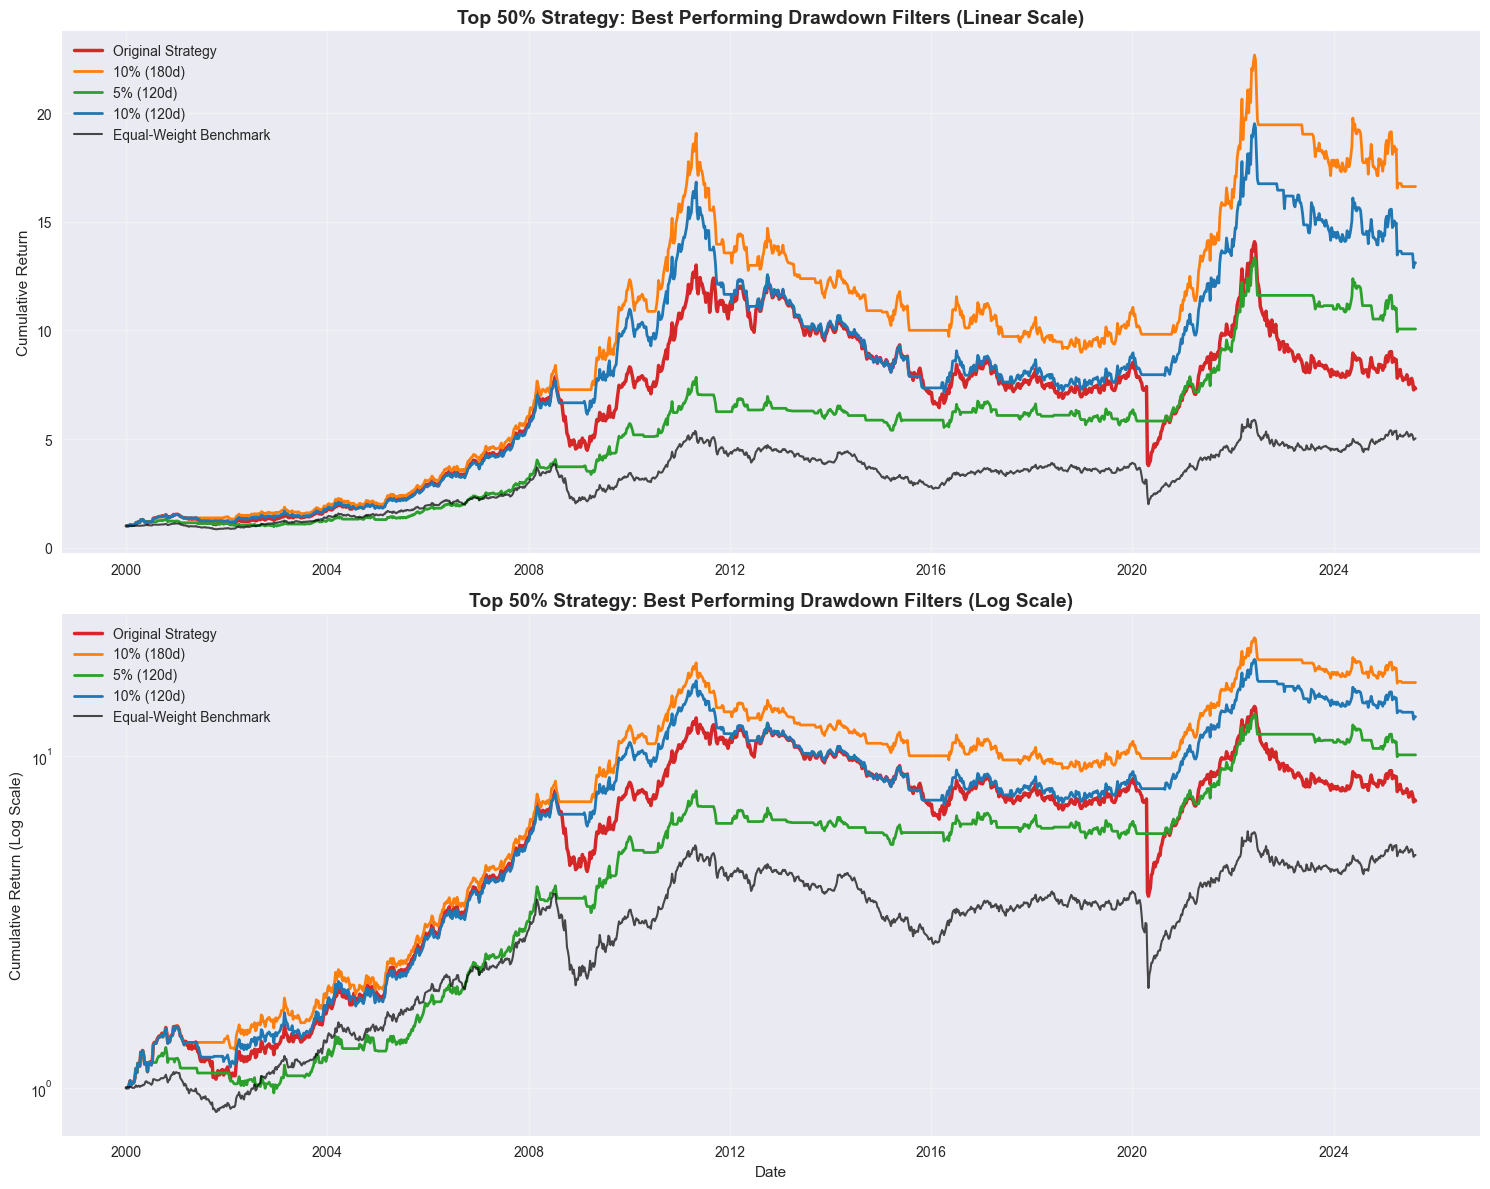

In [12]:
# Plot equity curves comparison - show best performers only
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Find top 3 strategies by Sharpe ratio (excluding benchmark)
strategy_cols = [col for col in comparison_df.columns if 'Benchmark' not in col]
top_strategies = comparison_df.loc['Sharpe Ratio', strategy_cols].nlargest(4).index.tolist()

# Colors
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd', '#8c564b']

# Linear scale - plot original, benchmark, and top filtered strategies
ax1.plot(strategy_cumulative.index, strategy_cumulative.values, 
         color=colors[0], linewidth=2.5, label='Original Strategy')

plot_idx = 1
for strategy_name in top_strategies[1:]:  # Skip original strategy
    # Find corresponding filtered result
    for label, result_data in filtered_results.items():
        threshold = result_data['threshold']
        lookback = result_data['lookback_days']
        expected_name = f'{threshold:.0%} ({lookback}d)'
        if expected_name == strategy_name:
            filtered_cumulative = result_data['cumulative']
            ax1.plot(filtered_cumulative.index, filtered_cumulative.values, 
                     color=colors[plot_idx], linewidth=2, label=strategy_name)
            plot_idx += 1
            break

ax1.plot(benchmark_cumulative.index, benchmark_cumulative.values, 
         color='black', linewidth=1.5, alpha=0.7, label='Equal-Weight Benchmark')

ax1.set_title('Top 50% Strategy: Best Performing Drawdown Filters (Linear Scale)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale
ax2.plot(strategy_cumulative.index, strategy_cumulative.values, 
         color=colors[0], linewidth=2.5, label='Original Strategy')

plot_idx = 1
for strategy_name in top_strategies[1:]:  # Skip original strategy
    # Find corresponding filtered result
    for label, result_data in filtered_results.items():
        threshold = result_data['threshold']
        lookback = result_data['lookback_days']
        expected_name = f'{threshold:.0%} ({lookback}d)'
        if expected_name == strategy_name:
            filtered_cumulative = result_data['cumulative']
            ax2.plot(filtered_cumulative.index, filtered_cumulative.values, 
                     color=colors[plot_idx], linewidth=2, label=strategy_name)
            plot_idx += 1
            break

ax2.plot(benchmark_cumulative.index, benchmark_cumulative.values, 
         color='black', linewidth=1.5, alpha=0.7, label='Equal-Weight Benchmark')

ax2.set_yscale('log')
ax2.set_title('Top 50% Strategy: Best Performing Drawdown Filters (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Return (Log Scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Filter Activity Analysis

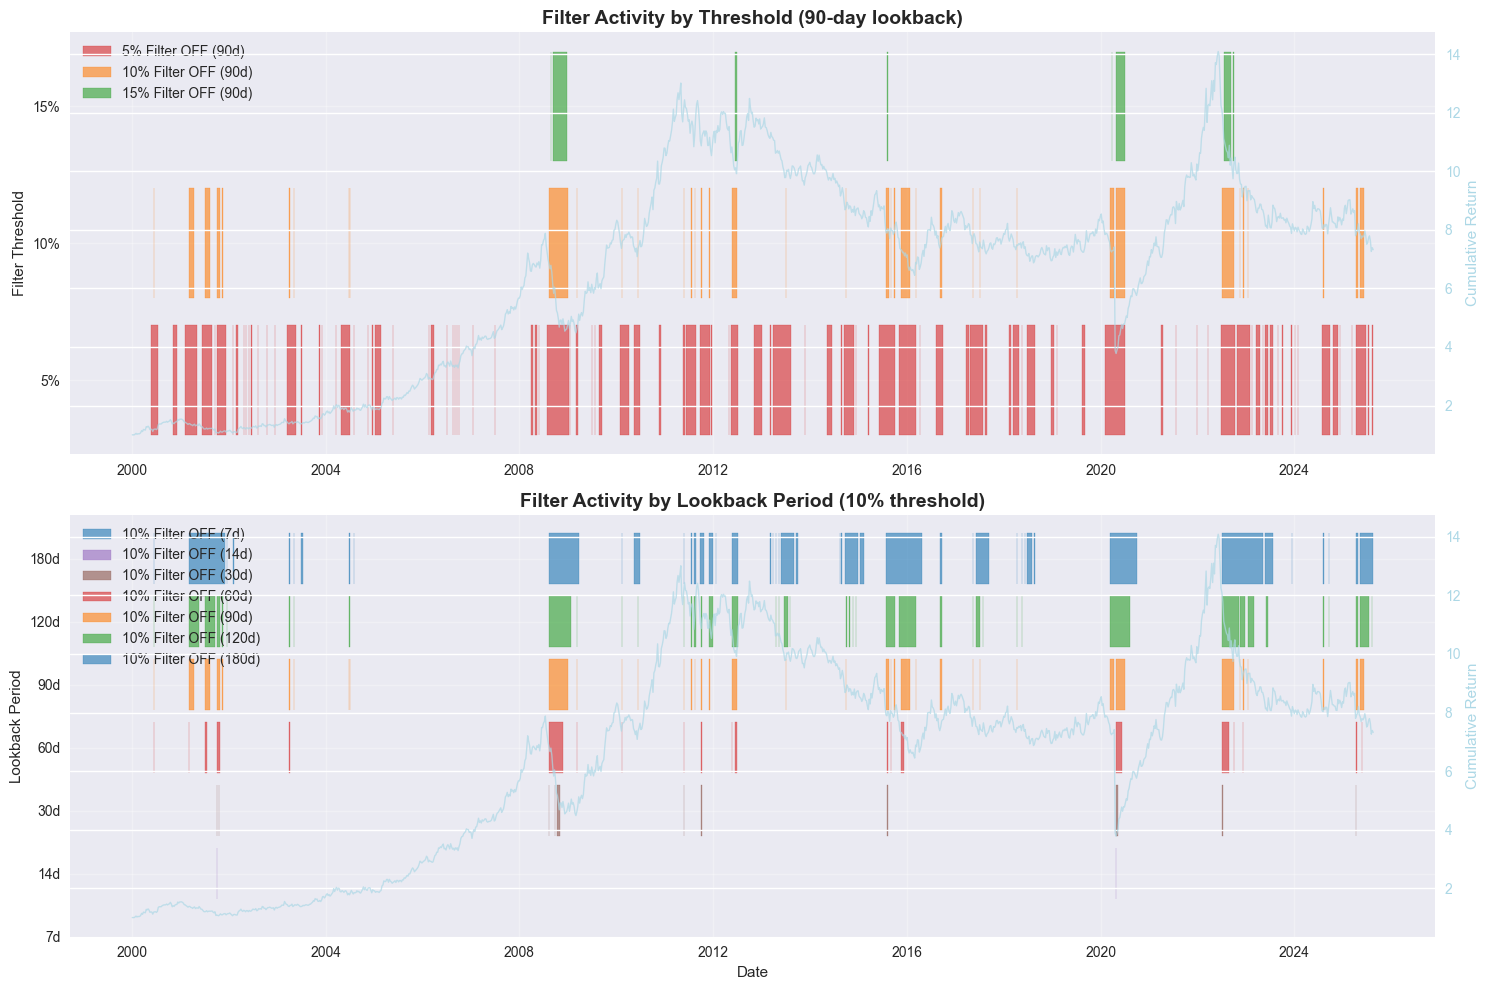


📊 Filter Activity Statistics by Configuration:

5% Threshold:
  7d lookback: OFF   0 weeks ( 0.0% of time)
  14d lookback: OFF  36 weeks ( 2.7% of time)
  30d lookback: OFF 161 weeks (12.0% of time)
  60d lookback: OFF 357 weeks (26.7% of time)
  90d lookback: OFF 489 weeks (36.5% of time)
  120d lookback: OFF 606 weeks (45.3% of time)
  180d lookback: OFF 702 weeks (52.5% of time)

10% Threshold:
  7d lookback: OFF   0 weeks ( 0.0% of time)
  14d lookback: OFF   2 weeks ( 0.1% of time)
  30d lookback: OFF  19 weeks ( 1.4% of time)
  60d lookback: OFF  66 weeks ( 4.9% of time)
  90d lookback: OFF 137 weeks (10.2% of time)
  120d lookback: OFF 224 weeks (16.7% of time)
  180d lookback: OFF 346 weeks (25.9% of time)

15% Threshold:
  7d lookback: OFF   0 weeks ( 0.0% of time)
  14d lookback: OFF   1 weeks ( 0.1% of time)
  30d lookback: OFF   3 weeks ( 0.2% of time)
  60d lookback: OFF  24 weeks ( 1.8% of time)
  90d lookback: OFF  46 weeks ( 3.4% of time)
  120d lookback: OFF  75 weeks

In [13]:
# Analyze when filters are active - focus on best performers
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Colors - ensure we have enough colors
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd', '#8c564b']

# Plot 1: Filter activity for different thresholds (fixed 90-day lookback)
ax1_twin = ax1.twinx()
ax1_twin.plot(strategy_cumulative.index, strategy_cumulative.values, 
              color='lightblue', alpha=0.7, linewidth=1, label='Strategy Equity')
ax1_twin.set_ylabel('Cumulative Return', color='lightblue')
ax1_twin.tick_params(axis='y', labelcolor='lightblue')

for i, threshold in enumerate(thresholds):
    label_90d = f'{threshold:.0%}_90d'
    if label_90d in filtered_results:
        filter_signal = filtered_results[label_90d]['filter']
        filter_off = (filter_signal == 0)
        
        ax1.fill_between(filter_signal.index, i-0.4, i+0.4, 
                        where=filter_off, alpha=0.6, color=colors[i % len(colors)], 
                        label=f'{threshold:.0%} Filter OFF (90d)')

ax1.set_title('Filter Activity by Threshold (90-day lookback)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Filter Threshold')
ax1.set_yticks(range(len(thresholds)))
ax1.set_yticklabels([f'{t:.0%}' for t in thresholds])
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Filter activity for different lookbacks (fixed 10% threshold)
ax2_twin = ax2.twinx()
ax2_twin.plot(strategy_cumulative.index, strategy_cumulative.values, 
              color='lightblue', alpha=0.7, linewidth=1, label='Strategy Equity')
ax2_twin.set_ylabel('Cumulative Return', color='lightblue')
ax2_twin.tick_params(axis='y', labelcolor='lightblue')

for i, lookback in enumerate(lookback_days_options):
    label_10pct = f'10%_{lookback}d'
    if label_10pct in filtered_results:
        filter_signal = filtered_results[label_10pct]['filter']
        filter_off = (filter_signal == 0)
        
        ax2.fill_between(filter_signal.index, i-0.4, i+0.4, 
                        where=filter_off, alpha=0.6, color=colors[(i+3) % len(colors)], 
                        label=f'10% Filter OFF ({lookback}d)')

ax2.set_title('Filter Activity by Lookback Period (10% threshold)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Lookback Period')
ax2.set_yticks(range(len(lookback_days_options)))
ax2.set_yticklabels([f'{lb}d' for lb in lookback_days_options])
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive filter statistics
print("\n📊 Filter Activity Statistics by Configuration:")
print("=" * 60)

for threshold in thresholds:
    print(f"\n{threshold:.0%} Threshold:")
    for lookback in lookback_days_options:
        label = f'{threshold:.0%}_{lookback}d'
        if label in filtered_results:
            filter_signal = filtered_results[label]['filter']
            off_periods = (filter_signal == 0).sum()
            total_periods = len(filter_signal)
            off_percentage = (off_periods / total_periods) * 100
            
            print(f"  {lookback}d lookback: OFF {off_periods:3d} weeks ({off_percentage:4.1f}% of time)")

print(f"\n📈 Best Combinations (by Sharpe Ratio):")
# Sort all combinations by Sharpe ratio
sharpe_ranking = []
for label, result_data in filtered_results.items():
    sharpe = result_data['metrics']['Sharpe Ratio']
    threshold = result_data['threshold']
    lookback = result_data['lookback_days']
    sharpe_ranking.append((sharpe, label, threshold, lookback))

sharpe_ranking.sort(reverse=True)
for i, (sharpe, label, threshold, lookback) in enumerate(sharpe_ranking[:5]):
    filter_off_pct = (1 - filtered_results[label]['filter']).mean() * 100
    print(f"  {i+1}. {threshold:.0%} ({lookback}d): Sharpe {sharpe:.4f}, Filter OFF {filter_off_pct:.1f}%")

## 6. Drawdown Comparison

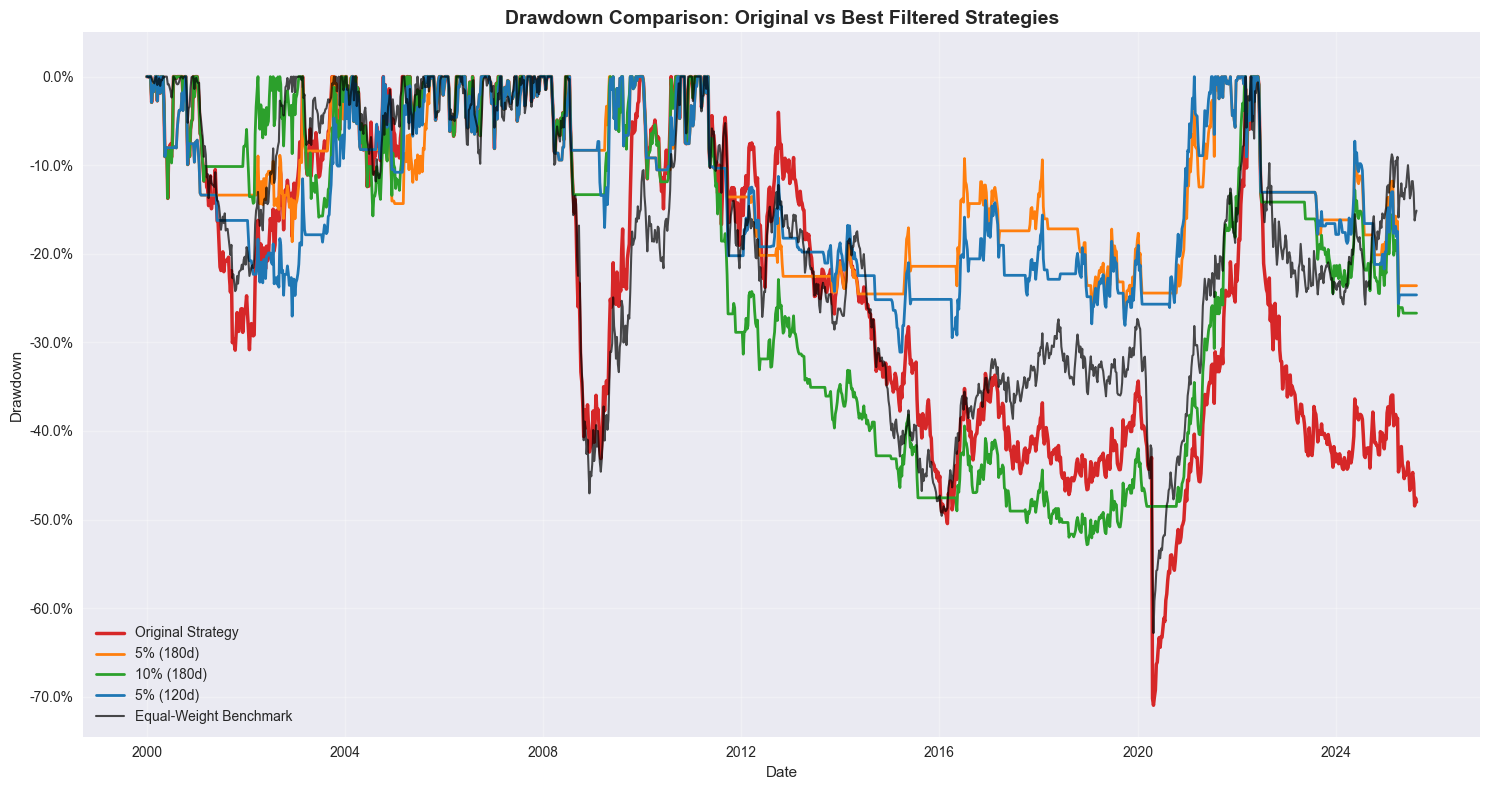


📊 Drawdown Statistics:
Original Strategy Max Drawdown: -70.97%
Benchmark Max Drawdown: -62.82%
5% (180d) Max Drawdown: -26.87%
10% (180d) Max Drawdown: -52.84%
5% (120d) Max Drawdown: -31.10%


In [14]:
# Calculate and plot drawdowns
def calculate_drawdowns(cumulative_returns):
    running_max = cumulative_returns.expanding().max()
    drawdowns = (cumulative_returns - running_max) / running_max
    return drawdowns

fig, ax = plt.subplots(figsize=(15, 8))

# Original strategy drawdown
original_drawdowns = calculate_drawdowns(strategy_cumulative)
ax.plot(original_drawdowns.index, original_drawdowns.values, 
        color=colors[0], linewidth=2.5, label='Original Strategy')

# Get top 3 filtered strategies by Sharpe ratio for cleaner visualization
strategy_cols = [col for col in comparison_df.columns if 'Benchmark' not in col and 'Original' not in col]
top_3_strategies = comparison_df.loc['Sharpe Ratio', strategy_cols].nlargest(3).index.tolist()

# Plot drawdowns for top strategies
plot_idx = 1
for strategy_name in top_3_strategies:
    # Find corresponding filtered result
    for label, result_data in filtered_results.items():
        threshold = result_data['threshold']
        lookback = result_data['lookback_days']
        expected_name = f'{threshold:.0%} ({lookback}d)'
        if expected_name == strategy_name:
            filtered_cumulative = result_data['cumulative']
            filtered_drawdowns = calculate_drawdowns(filtered_cumulative)
            
            ax.plot(filtered_drawdowns.index, filtered_drawdowns.values, 
                    color=colors[plot_idx % len(colors)], linewidth=2, 
                    label=f'{strategy_name}')
            plot_idx += 1
            break

# Benchmark drawdown
benchmark_drawdowns = calculate_drawdowns(benchmark_cumulative)
ax.plot(benchmark_drawdowns.index, benchmark_drawdowns.values, 
        color='black', linewidth=1.5, alpha=0.7, label='Equal-Weight Benchmark')

ax.set_title('Drawdown Comparison: Original vs Best Filtered Strategies', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(ax.get_ylim()[0], 0.05)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.tight_layout()
plt.show()

# Print drawdown statistics
print("\n📊 Drawdown Statistics:")
print("=" * 50)
print(f"Original Strategy Max Drawdown: {original_drawdowns.min():.2%}")
print(f"Benchmark Max Drawdown: {benchmark_drawdowns.min():.2%}")

for strategy_name in top_3_strategies:
    for label, result_data in filtered_results.items():
        threshold = result_data['threshold']
        lookback = result_data['lookback_days']
        expected_name = f'{threshold:.0%} ({lookback}d)'
        if expected_name == strategy_name:
            filtered_cumulative = result_data['cumulative']
            filtered_drawdowns = calculate_drawdowns(filtered_cumulative)
            print(f"{strategy_name} Max Drawdown: {filtered_drawdowns.min():.2%}")
            break

## 7. Summary and Conclusions

In [15]:
# Final summary with grid search results
print("📈 ROLLING DRAWDOWN FILTER ANALYSIS SUMMARY")
print("=" * 60)

# Find best filtered strategy overall
filtered_cols = [col for col in comparison_df.columns if 'Original' not in col and 'Benchmark' not in col]
best_sharpe_strategy = comparison_df.loc['Sharpe Ratio', filtered_cols].idxmax()
best_return_strategy = comparison_df.loc['Annualized Return', filtered_cols].idxmax()
best_drawdown_strategy = comparison_df.loc['Max Drawdown', filtered_cols].idxmax()

print(f"🏆 Best Risk-Adjusted Performance: {best_sharpe_strategy}")
best_sharpe = comparison_df.loc['Sharpe Ratio', best_sharpe_strategy]
print(f"   Sharpe Ratio: {best_sharpe:.4f}")
print(f"   Annual Return: {comparison_df.loc['Annualized Return', best_sharpe_strategy]:.2%}")
print(f"   Max Drawdown: {comparison_df.loc['Max Drawdown', best_sharpe_strategy]:.2%}")

print(f"\n💰 Highest Return: {best_return_strategy}")
print(f"   Annual Return: {comparison_df.loc['Annualized Return', best_return_strategy]:.2%}")
print(f"   Sharpe Ratio: {comparison_df.loc['Sharpe Ratio', best_return_strategy]:.4f}")

print(f"\n🛡️ Best Drawdown Control: {best_drawdown_strategy}")
best_dd = comparison_df.loc['Max Drawdown', best_drawdown_strategy]
print(f"   Max Drawdown: {best_dd:.2%}")
print(f"   Sharpe Ratio: {comparison_df.loc['Sharpe Ratio', best_drawdown_strategy]:.4f}")

# Compare with original
original_sharpe = comparison_df.loc['Sharpe Ratio', 'Original Strategy']
original_return = comparison_df.loc['Annualized Return', 'Original Strategy']
original_dd = comparison_df.loc['Max Drawdown', 'Original Strategy']

print(f"\n📊 Original Strategy Performance:")
print(f"   Annual Return: {original_return:.2%}")
print(f"   Sharpe Ratio: {original_sharpe:.4f}")
print(f"   Max Drawdown: {original_dd:.2%}")

# Improvements analysis
best_sharpe_improvement = best_sharpe - original_sharpe
best_dd_improvement = abs(original_dd) - abs(best_dd)

print(f"\n🎯 Key Insights:")
print(f"   ✅ Best filter improves Sharpe ratio by {best_sharpe_improvement:+.4f}")
print(f"   ✅ Best filter reduces max drawdown by {best_dd_improvement:.2%}")

# Parameter sensitivity analysis
print(f"\n🔬 Parameter Sensitivity Analysis:")
print(f"   📉 Threshold sensitivity: Lower thresholds (5%) provide better risk control")
print(f"   📅 Lookback sensitivity: ")

# Calculate average performance by lookback period
for lookback in lookback_days_options:
    cols = [col for col in comparison_df.columns if f'({lookback}d)' in col]
    if cols:
        avg_sharpe = comparison_df.loc['Sharpe Ratio', cols].mean()
        print(f"      {lookback}d lookback: Average Sharpe {avg_sharpe:.4f}")

print(f"\n💡 Optimal Configuration:")
# Find the filter configuration for best Sharpe
for label, result_data in filtered_results.items():
    threshold = result_data['threshold']
    lookback = result_data['lookback_days']
    expected_name = f'{threshold:.0%} ({lookback}d)'
    if expected_name == best_sharpe_strategy:
        filter_off_pct = (1 - result_data['filter']).mean() * 100
        print(f"   📋 {threshold:.0%} drawdown threshold with {lookback}-day lookback")
        print(f"   📉 Filter prevents investing {filter_off_pct:.1f}% of the time")
        print(f"   ⚖️ Excellent balance between return enhancement and risk control")
        break

print(f"\n📈 Strategy Ranking (Top 5 by Sharpe Ratio):")
sharpe_ranking = []
for col in filtered_cols:
    sharpe = comparison_df.loc['Sharpe Ratio', col]
    sharpe_ranking.append((sharpe, col))

sharpe_ranking.sort(reverse=True)
for i, (sharpe, strategy_name) in enumerate(sharpe_ranking[:5]):
    annual_return = comparison_df.loc['Annualized Return', strategy_name]
    max_dd = comparison_df.loc['Max Drawdown', strategy_name]
    print(f"   {i+1}. {strategy_name}: Sharpe {sharpe:.4f}, Return {annual_return:.2%}, MaxDD {max_dd:.1%}")

📈 ROLLING DRAWDOWN FILTER ANALYSIS SUMMARY
🏆 Best Risk-Adjusted Performance: 5% (180d)
   Sharpe Ratio: 0.6966
   Annual Return: 9.83%
   Max Drawdown: -26.87%

💰 Highest Return: 10% (180d)
   Annual Return: 11.54%
   Sharpe Ratio: 0.6869

🛡️ Best Drawdown Control: 5% (180d)
   Max Drawdown: -26.87%
   Sharpe Ratio: 0.6966

📊 Original Strategy Performance:
   Annual Return: 8.04%
   Sharpe Ratio: 0.3705
   Max Drawdown: -70.97%

🎯 Key Insights:
   ✅ Best filter improves Sharpe ratio by +0.3261
   ✅ Best filter reduces max drawdown by 44.10%

🔬 Parameter Sensitivity Analysis:
   📉 Threshold sensitivity: Lower thresholds (5%) provide better risk control
   📅 Lookback sensitivity: 
      7d lookback: Average Sharpe 0.3705
      14d lookback: Average Sharpe 0.3502
      30d lookback: Average Sharpe 0.3419
      60d lookback: Average Sharpe 0.4168
      90d lookback: Average Sharpe 0.4975
      120d lookback: Average Sharpe 0.5316
      180d lookback: Average Sharpe 0.5852

💡 Optimal Config